# Appear Here Test

Pauline Guilmin

January 2019

# import libraries

In [5]:
import numpy as np 
import pandas as pd
pd.options.display.max_colwidth = 500
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
!pwd

/Users/paguilmin/Documents/AppearHere_Test/analysis


# Charge data

In [7]:
path = '../data/'
ideas = pd.read_csv(path+'ideas.csv',sep=',')
transitions = pd.read_csv(path+'transitions.csv',sep=',')

## cleaning

In [8]:
ideas = ideas.drop(['Unnamed: 0'],axis=1)
transitions.columns
transitions = transitions.drop(['Unnamed: 0'],axis=1)

In [9]:
# some dates are not rigth written : 0019 instead of 2019 and 0020 instead of 2020
transitions.loc[transitions['start_on'].str.startswith('2')==False,'start_on'] = \
transitions.loc[transitions['start_on'].str.startswith('2')==False,'start_on'].str.replace('0019','2019')
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'] = \
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'].str.replace('0020','2020')
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'] = \
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'].str.replace('0019','2019')

## datetimes

In [10]:
transitions.loc[:,'transition_ts'] = pd.to_datetime(transitions.loc[:,'transition_ts'])
transitions.loc[:,'start_on'] = pd.to_datetime(transitions.loc[:,'start_on'])
transitions.loc[:,'end_on'] = pd.to_datetime(transitions.loc[:,'end_on'])

ideas.loc[:,'created_at'] = pd.to_datetime(ideas.loc[:,'created_at'])

## sort

In [11]:
transitions = transitions.sort_values(['idea_id','space_id','transition_ts'])

# useful fonctions

In [12]:
def top_champ(df,feature,number) :
    df_ok = df.copy()
    df_ok[feature] = df_ok[feature].fillna('unknown')
    top_10 = df_ok.groupby(feature).agg('size').sort_values(ascending=False).to_frame().reset_index()
    top_10.columns=[str(x) for x in feature]+['nb_records']
    top_10['percentage']=(100.* (top_10['nb_records'] / top_10['nb_records'].sum())).round(2)
    print('%0.0f distinct values for the feature %s' %(top_10.shape[0],feature))
    return top_10.head(number)

# ideas exploration

In [13]:
print('ideas csv contains %0.0f rows and %0.0f columns' %(ideas.shape[0],ideas.shape[1]))
ideas.nunique()

ideas csv contains 4000 rows and 3 columns


created_at    4000
category         6
idea_id       4000
dtype: int64

In [14]:
top_champ(ideas,['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,2174,54.35
1,private_event,546,13.65
2,popup_bar,533,13.32
3,unique,398,9.95
4,gallery,282,7.05
5,sample_sale,67,1.68


In [15]:
min_created = min(ideas['created_at'])
max_created = max(ideas['created_at'])
print('Ideas have been created from %s to %s' %(min_created, max_created))

Ideas have been created from 2018-01-01 17:01:01.489000 to 2019-01-21 10:19:35.205000


# transitions exploration

In [16]:
print('transitions csv contains %0.0f rows and %0.0f columns' %(transitions.shape[0],transitions.shape[1]))
transitions.nunique()

transitions csv contains 21062 rows and 14 columns


transition_ts         21062
category                  6
idea_id                2677
booking_request_id     9942
to_state                  4
space_id               2065
country                   3
city                    110
portfolio_type            9
floor_size              548
floor_size_unit           2
start_on                503
end_on                  618
price                  3593
dtype: int64

In [17]:
transitions['to_state_bf']= transitions['to_state'].shift(1)
transitions['to_state_af']= transitions['to_state'].shift(-1)
transitions['time_booked'] = transitions.loc[:,'end_on']- transitions.loc[:,'start_on']
transitions.loc[:,'time_booked'] = transitions.loc[:,'time_booked']/ np.timedelta64(1, 'D')

In [18]:
id_bk_notime = transitions.loc[transitions['time_booked']==0,'booking_request_id'].unique()

In [19]:
states_ideas = transitions.groupby(['idea_id','to_state']).agg('size').to_frame().reset_index()
idea_id_booked = states_ideas.loc[states_ideas['to_state']=='booked','idea_id'].unique()
print('Above 4000 ideas %0.0f ideas have been booked at least one time' %len(idea_id_booked))
#states_ideas[states_ideas['idea_id'].isin(idea_id_booked)]


Above 4000 ideas 328 ideas have been booked at least one time


In [20]:
top_champ(transitions[transitions['to_state']=='matched'],['to_state_af'],10)

4 distinct values for the feature ['to_state_af']


,to_state_af,nb_records,percentage
0,declined,2125,78.88
1,booked,388,14.40
2,submitted,117,4.34
3,matched,64,2.38


In [21]:
transitions.loc[(transitions['to_state']=='booked') &
           (transitions['to_state_bf']=='declined'),'idea_id'].unique()

array([ 105,  230,  245,  323,  430,  449,  451,  834,  902,  917, 1094,
       1154, 1335, 1535, 1692, 1698, 1794, 1919, 2161, 2214, 2789, 2846,
       3034, 3183, 3329, 3510, 3791, 3861, 3896, 3926])

In [22]:
#transitions[transitions['space_id']==6735]
#transitions[transitions['idea_id']==105]

## floor size

Floor size unit : 0
count    15269.000000
mean      1477.198572
std       2955.878932
min          1.000000
25%        300.000000
50%        750.000000
75%       1700.000000
max      50000.000000
Name: floor_size, dtype: float64
Floor size unit : 1

count    5793.000000
mean      109.032971
std       218.851472
min         2.000000
25%        33.000000
50%        55.000000
75%       110.000000
max      4700.000000
Name: floor_size, dtype: float64

Boxplot depending floor size unit

It seems to be 0 for sq feets and 1 for sq meters as  : 1 feet^2 = 0.09 m^2


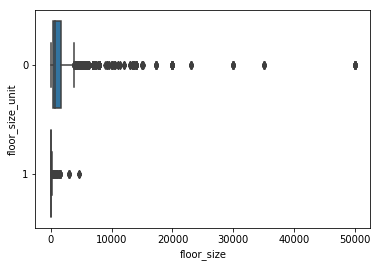

In [23]:
# Let's check the difference between floor size unit 0 and 1 
print('Floor size unit : 0')
print(transitions.loc[transitions['floor_size_unit']==0,'floor_size'].describe())
print('Floor size unit : 1\n')
print(transitions.loc[transitions['floor_size_unit']==1,'floor_size'].describe())

print('\nBoxplot depending floor size unit')
sns.boxplot(x=transitions.floor_size, y=transitions.floor_size_unit,orient="h")
print('\nIt seems to be 0 for sq feets and 1 for sq meters as  : 1 feet^2 = 0.09 m^2')

In [24]:
#verification ok 
transitions.groupby(['country','floor_size_unit']).agg('size')

country  floor_size_unit
FR       1                   5787
GB       0                  11664
         1                      6
US       0                   3605
dtype: int64

In [25]:
# put all in sq meters 
transitions.loc[:,'floor_size_m']=transitions.loc[:,'floor_size']
print(transitions.loc[:,'floor_size_m'].describe())
transitions.loc[transitions['floor_size_unit']==0,'floor_size_m']=round(transitions.loc[:,'floor_size_m']*0.09)
print(transitions.loc[:,'floor_size_m'].describe())
#anomaly sq meters below 1 
transitions = transitions.loc[transitions['floor_size_m']>1]

count    21062.000000
mean      1100.891321
std       2592.375283
min          1.000000
25%         65.000000
50%        400.000000
75%       1175.000000
max      50000.000000
Name: floor_size_m, dtype: float64
count    21062.000000
mean       126.362928
std        254.152606
min          0.000000
25%         29.000000
50%         63.000000
75%        140.000000
max       4700.000000
Name: floor_size_m, dtype: float64


In [26]:
transitions.loc[transitions['floor_size_m']>   200,'floor_size_cat'] = 'sup_200'
transitions.loc[transitions['floor_size_m']<=  200,'floor_size_cat'] = '100_200'
transitions.loc[transitions['floor_size_m']<   100,'floor_size_cat'] = '80_100'
transitions.loc[transitions['floor_size_m']<    80,'floor_size_cat'] = '60_80'
transitions.loc[transitions['floor_size_m']<    60,'floor_size_cat'] = '40_60'
transitions.loc[transitions['floor_size_m']<    40,'floor_size_cat'] = '20_40'
transitions.loc[transitions['floor_size_m']<    20,'floor_size_cat'] = 'inf_20'

In [27]:
top_champ(transitions,['floor_size_cat'],10)

7 distinct values for the feature ['floor_size_cat']


,floor_size_cat,nb_records,percentage
0,100_200,3711,18.11
1,20_40,3659,17.86
2,sup_200,3256,15.89
3,40_60,3049,14.88
4,inf_20,2814,13.73
5,60_80,2156,10.52
6,80_100,1847,9.01


## prices

different prices for each space which means : each price depends also from other parameters such as       the time booked and floor size


/anaconda/envs/ah_test_env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


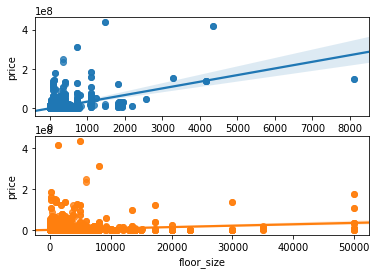

In [28]:
transitions.groupby(['space_id','price']).agg('size').to_frame().reset_index()
print('different prices for each space which means : each price depends also from other parameters such as \
      the time booked and floor size')
f, (ax1, ax2) = plt.subplots(2, 1)
sns.regplot(x='time_booked', y="price", data=transitions,ax=ax1)
sns.regplot(x='floor_size', y="price", data=transitions,ax=ax2)

count    2.049200e+04
mean     1.858296e+06
std      1.058641e+07
min      0.000000e+00
25%      9.000000e+04
50%      2.800000e+05
75%      9.121248e+05
max      4.386000e+08
Name: price, dtype: float64


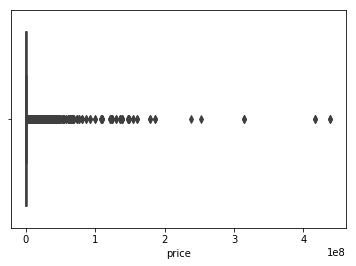

In [29]:
# Let's check the difference between floor size unit 0 and 1 
print(transitions.price.describe())
sns.boxplot(x=transitions.price)
# It seems to be 0 for sq meters and 1 for sq feets as  : 1 feet^2 = 0.09 m^2
#anomaly price equals 0
transitions = transitions[transitions['price']!=0]
transitions.loc[transitions['price']>   5000000,'price_category'] = 'sup_5millions'
transitions.loc[transitions['price']<=  5000000,'price_category'] = '1_5millions'
transitions.loc[transitions['price']<   1000000,'price_category'] = '500k_1millions'
transitions.loc[transitions['price']<    500000,'price_category'] = '200k_500k'
transitions.loc[transitions['price']<    300000,'price_category'] = '100k_200k'
transitions.loc[transitions['price']<    100000,'price_category'] = '50k_100k'
transitions.loc[transitions['price']<     50000,'price_category'] = '10k_50k'
transitions.loc[transitions['price']<     10000,'price_category'] = 'inf_10k'

In [30]:
top_champ(transitions,['price_category'],10)

8 distinct values for the feature ['price_category']


,price_category,nb_records,percentage
0,100k_200k,5085,24.84
1,1_5millions,3685,18.00
2,500k_1millions,2674,13.06
3,10k_50k,2651,12.95
4,200k_500k,2365,11.55
5,50k_100k,2253,11.00
6,sup_5millions,1230,6.01
7,inf_10k,532,2.60


## city

In [31]:
import re
transitions.loc[:,'city_ok'] = transitions.loc[:,'city']\
.apply(lambda x : re.sub("\W", " ",x))

In [32]:
transitions.loc[:,'city_ok'] = transitions.loc[:,'city_ok'].str.lower().str.strip()

transitions.loc[transitions['city_ok']\
               .isin(['new york','nyc','new york city']),'city_ok']\
                     = 'new york'
transitions.loc[transitions['city_ok']\
               .str.startswith('paris'),'city_ok']\
                     = 'paris'

In [33]:
transitions.loc[:,'capitale']= 'no'
transitions.loc[transitions['city_ok']\
               .isin(['paris','new york','london']),'capitale']\
                     = 'yes'

In [34]:
top_champ(transitions,['country'],100)

3 distinct values for the feature ['country']


,country,nb_records,percentage
0,GB,11085,54.14
1,FR,5787,28.26
2,US,3603,17.60


# total exploration

In [35]:
total = pd.merge(ideas, transitions, how='left', left_on='idea_id',right_on='idea_id')

In [36]:
total.loc[:,'time_after_creation'] = total.loc[:,'transition_ts']- total.loc[:,'created_at']
total.loc[:,'time_after_creation'] = total.loc[:,'time_after_creation']/ np.timedelta64(1, 'D')
total_first = total.drop_duplicates('idea_id')
top_champ(total_first,['to_state'],10)

4 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted,2324,58.10
1,unknown,1379,34.48
2,declined,296,7.40
3,booked,1,0.02


In [37]:
total_first.loc[:,'time_after_creation'].describe()
print(total[total['category_x']!=total['category_y']].shape)
print(total[total['category_y'].isnull()].shape)
#idem
# 1323 ideas without 

(1379, 25)
(1379, 25)


In [38]:
idea_id_unknown = total.loc[total['category_y'].isnull(),'idea_id'].unique()
min_created_ukn = min(ideas.loc[ideas['idea_id'].isin(idea_id_unknown),'created_at'])
max_created_ukn = max(ideas.loc[ideas['idea_id'].isin(idea_id_unknown),'created_at'])
print('There are %0.0f ideas unknown' %len(idea_id_unknown))
print('Ideas unknown have been created from %s to %s' %(min_created_ukn, max_created_ukn))
idea_id_known = total.loc[total['category_y'].notnull(),'idea_id'].unique()
min_created_ukn = min(ideas.loc[ideas['idea_id'].isin(idea_id_known),'created_at'])
max_created_ukn = max(ideas.loc[ideas['idea_id'].isin(idea_id_known),'created_at'])
print('There are %0.0f ideas with at least one request submitted' %(len(idea_id_known)))
print('Ideas with requests have been created from %s to %s' %(min_created_ukn, max_created_ukn))

There are 1379 ideas unknown
Ideas unknown have been created from 2018-01-01 17:01:01.489000 to 2019-01-21 10:19:35.205000
There are 2621 ideas with at least one request submitted
Ideas with requests have been created from 2018-01-02 15:21:32.044000 to 2019-01-15 14:54:49.719000


In [39]:
top_champ(ideas[ideas['idea_id'].isin(idea_id_unknown)],['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,760,55.11
1,popup_bar,240,17.40
2,unique,145,10.51
3,private_event,134,9.72
4,gallery,78,5.66
5,sample_sale,22,1.60


In [40]:
top_champ(ideas[ideas['idea_id'].isin(idea_id_known)],['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,1414,53.95
1,private_event,412,15.72
2,popup_bar,293,11.18
3,unique,253,9.65
4,gallery,204,7.78
5,sample_sale,45,1.72


In [41]:
total_ok = total.loc[total['idea_id'].isin(idea_id_known)]

In [42]:
total_ok['time_after_creation'].describe()

count    2.047500e+04
mean     2.350080e+01
std      4.889505e+01
min      6.250000e-07
25%      1.153481e-01
50%      4.062131e+00
75%      2.003718e+01
max      3.599833e+02
Name: time_after_creation, dtype: float64

In [43]:
total_ok.loc[total_ok['time_after_creation']>15,'after_creation']='sup_15j'
total_ok.loc[total_ok['time_after_creation']<=15,'after_creation']='3j_15j'
total_ok.loc[total_ok['time_after_creation']<3,'after_creation']='1j_3j'
total_ok.loc[total_ok['time_after_creation']<1,'after_creation']='1h_1j'
total_ok.loc[total_ok['time_after_creation']<0.04,'after_creation']='10s_1h'
total_ok.loc[total_ok['time_after_creation']<0.0001,'after_creation']='less_10s'

/anaconda/envs/ah_test_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda/envs/ah_test_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
top_champ(total_ok.drop_duplicates('idea_id'),['after_creation'],10)
# More than an half of the ideas transforms in a request in less than 10 seconds

6 distinct values for the feature ['after_creation']


,after_creation,nb_records,percentage
0,less_10s,1521,58.03
1,sup_15j,282,10.76
2,3j_15j,274,10.45
3,10s_1h,231,8.81
4,1h_1j,200,7.63
5,1j_3j,113,4.31


In [45]:
total_ok[['transition_ts','idea_id','space_id','to_state']][0:10]

,transition_ts,idea_id,space_id,to_state
2,2018-10-08 19:38:18.153,2,366.0,submitted
3,2018-10-10 12:19:26.197,2,366.0,declined
5,2018-06-10 16:05:47.226,4,5844.0,submitted
6,2018-06-26 15:55:27.471,4,5844.0,declined
7,2018-11-27 17:06:18.287,5,5241.0,submitted
8,2018-11-28 16:46:10.694,5,5241.0,matched
9,2018-12-01 01:03:33.476,5,5241.0,booked
10,2018-03-27 14:46:16.156,6,4035.0,submitted
11,2018-04-10 17:27:06.135,6,4035.0,declined
12,2018-03-27 14:46:16.313,6,5438.0,submitted


In [46]:
conversion = total_ok.groupby(['idea_id','space_id','booking_request_id'])['to_state'].\
apply(lambda x: "%s" % ' / '.join(x)).to_frame().reset_index()
#conversion
#top_champ(conversion,['to_state'],10)
conversion.loc[:,'ending_stage'] = conversion.loc[:,'to_state'].apply(lambda x : x.split(' ')[-1])

conversion_2 = conversion\
.join(conversion['to_state'].str.split(' / s', expand=True)\
      .stack().reset_index(level=1, drop=True).rename('to_state_2'))
conversion_2.loc[:,'to_state_2'] = conversion_2['to_state_2'].str.replace('ubmitted','submitted')
conversion_2.loc[:,'to_state_2'] = conversion_2['to_state_2'].str.replace('ssubmitted','submitted')
conversion_2.loc[:,'ending_stage_2'] = conversion_2.loc[:,'to_state_2'].apply(lambda x : x.split(' ')[-1])



In [71]:
top_champ(conversion,['idea_id','ending_stage'],3000)\
.sort_values(['ending_stage','nb_records'],ascending=True)
#conversion

2998 distinct values for the feature ['idea_id', 'ending_stage']


,idea_id,ending_stage,nb_records,percentage
1442,135,booked,1,0.01
1443,1212,booked,1,0.01
1445,275,booked,1,0.01
1450,1370,booked,1,0.01
1451,68,booked,1,0.01
1452,245,booked,1,0.01
1453,247,booked,1,0.01
1459,1225,booked,1,0.01
1463,1222,booked,1,0.01
1467,62,booked,1,0.01


In [48]:
#conversion['to_state_simpl'] = conversion['to_state'].str.split(' / ').apply(lambda x : list(map(itemgetter(0), groupby(x))))
#conversion['to_state_simpl']

In [49]:
top_champ(conversion[conversion.ending_stage=='submitted'],['to_state'],100)

4 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted,303,95.58
1,submitted / submitted,8,2.52
2,submitted / declined / submitted,5,1.58
3,submitted / submitted / submitted,1,0.32


In [50]:
#conversion[(conversion['to_state']=='submitted / declined / submitted / declined')]
#conversion[conversion['idea_id']==30]

In [51]:
top_champ(conversion_2,['to_state'],100)

59 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted / declined,4780,47.07
1,declined,1827,17.99
2,submitted / matched / declined,1753,17.26
3,submitted,303,2.98
4,submitted / matched / booked,297,2.92
5,submitted / submitted / declined,284,2.80
6,submitted / submitted / matched / declined,238,2.34
7,submitted / declined / submitted / declined,128,1.26
8,submitted / declined / submitted / matched / declined,68,0.67
9,submitted / matched,67,0.66


In [52]:
print(transitions.drop_duplicates(['booking_request_id','city','space_id']).shape)
transitions.drop_duplicates(['booking_request_id']).shape

(9676, 22)


(9676, 22)

In [53]:
test = total_ok[(total_ok['booking_request_id']==114598.0)]
test.iloc[:,10:20]\
#[['created_at','transition_ts','booking_request_id','space_id','to_state','start_on','end_on','time_booked']]

,portfolio_type,floor_size,floor_size_unit,start_on,end_on,price,to_state_bf,to_state_af,time_booked,floor_size_m
230,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,declined,declined,6.0,90.0
231,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,submitted,submitted,6.0,90.0
232,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,declined,declined,6.0,90.0
233,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,submitted,declined,6.0,90.0


# studies of bookings ok

In [55]:
bookings_ok = pd.merge(conversion[['booking_request_id','to_state','ending_stage']],
                      total_ok.drop_duplicates('booking_request_id')\
                       [['idea_id','booking_request_id',
                         'space_id','country', 'city','city_ok','capitale',
       'portfolio_type', 'floor_size', 'floor_size_unit','floor_size_cat',
                         'price','price_category',
       'time_booked', 'time_after_creation', 'after_creation']],\
                       how='inner', on = 'booking_request_id')

In [56]:
# reservation more than 1 day (without bug)
bookings_ok =bookings_ok[bookings_ok['time_booked']>0]

In [57]:
bookings_ok['time_booked'].describe()

count    7841.000000
mean       54.971815
std       192.477730
min         1.000000
25%         4.000000
50%         8.000000
75%        30.000000
max      8115.000000
Name: time_booked, dtype: float64

In [58]:
bookings_ok.loc[bookings_ok['time_booked']> 30,'times_booked_cat'] = 'sup_30'
bookings_ok.loc[bookings_ok['time_booked']<=30,'times_booked_cat'] = '15_30'
bookings_ok.loc[bookings_ok['time_booked']< 15,'times_booked_cat'] = '10_15'
bookings_ok.loc[bookings_ok['time_booked']< 10,'times_booked_cat'] = '7_10'
bookings_ok.loc[bookings_ok['time_booked']< 7,'times_booked_cat'] = '5_7'
bookings_ok.loc[bookings_ok['time_booked']< 5,'times_booked_cat'] = '3_5'
bookings_ok.loc[bookings_ok['time_booked']< 3,'times_booked_cat'] = 'inf_3'

In [59]:
top_champ(bookings_ok,['times_booked_cat'],100)

7 distinct values for the feature ['times_booked_cat']


,times_booked_cat,nb_records,percentage
0,sup_30,1699,21.67
1,inf_3,1548,19.74
2,5_7,1269,16.18
3,15_30,1139,14.53
4,10_15,867,11.06
5,3_5,671,8.56
6,7_10,648,8.26


In [654]:
bookings_ok.to_csv('bookings_ok.csv') 

In [526]:
# finished bookings : either declined or booking
bookings_ok = bookings_ok[bookings_ok['ending_stage'].isin(['declined','booked'])]

In [527]:
top_champ(bookings_ok,['ending_stage'],100)

2 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,declined,7354,95.79
1,booked,323,4.21


In [533]:
bookings_ok = bookings_ok[['ending_stage','country','city','portfolio_type','floor_size','floor_size_unit','time_booked','after_creation']]

bookings_ok.loc[bookings_ok['floor_size_unit']==1,'floor_size'].describe()
#bookings_ok.loc[bookings_ok['floor_size']>1000,'floor_size_ok'] = 



count    2397.000000
mean      102.333333
std       198.349074
min         2.000000
25%        31.000000
50%        50.000000
75%       108.000000
max      4700.000000
Name: floor_size, dtype: float64

In [529]:
bookings_ok.columns

Index(['booking_request_id', 'to_state', 'ending_stage', 'idea_id', 'space_id',
       'country', 'city', 'portfolio_type', 'floor_size', 'floor_size_unit',
       'time_booked', 'price', 'time_after_creation', 'after_creation'],
      dtype='object')

In [515]:
top_champ(bookings_ok,['portfolio_type'],10)

9 distinct values for the feature ['portfolio_type']


,portfolio_type,nb_records,percentage
0,3.0,4254,55.41
1,8.0,1517,19.76
2,7.0,479,6.24
3,4.0,328,4.27
4,5.0,320,4.17
5,1.0,270,3.52
6,6.0,243,3.17
7,2.0,162,2.11
8,0.0,104,1.35


# ML 

In [63]:
total_ok.columns

Index(['created_at', 'category_x', 'idea_id', 'transition_ts', 'category_y',
       'booking_request_id', 'to_state', 'space_id', 'country', 'city',
       'portfolio_type', 'floor_size', 'floor_size_unit', 'start_on', 'end_on',
       'price', 'to_state_bf', 'to_state_af', 'time_booked', 'floor_size_m',
       'floor_size_cat', 'price_category', 'city_ok', 'capitale',
       'time_after_creation', 'after_creation'],
      dtype='object')

Text(0.5, 1.0, 'Represents the correlations betweeen features')

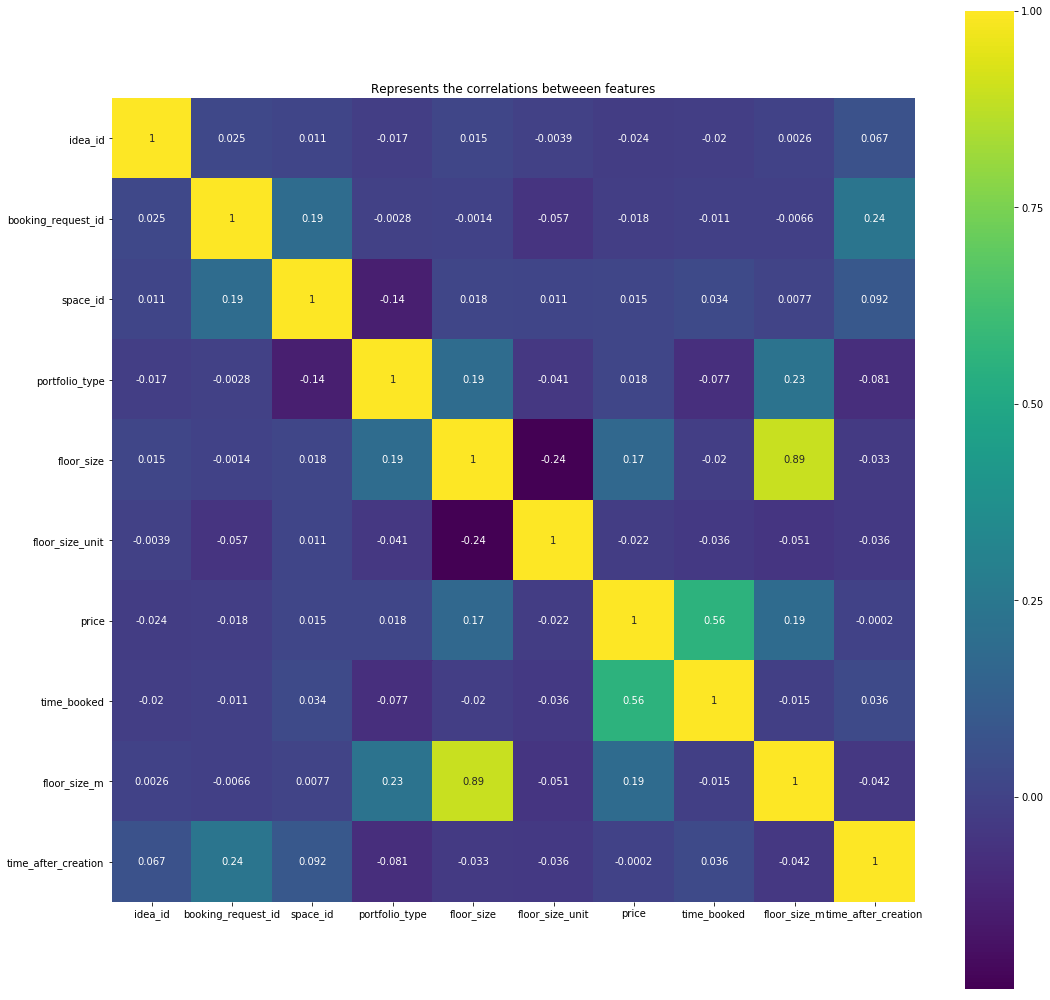

In [65]:
tab_corr = total_ok.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(tab_corr, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Represents the correlations betweeen features')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
X = bookings.iloc[:,0:4].values
y = df.iloc[:,4].values